# <center> PROCESAMIENTO DIGITAL DE SEÑALES DE AUDIO</center>
## <center> Dynamic Time Warping (DTW)</center>
### <center> Speech alignment example</center>

Code based on: [dp_python](https://github.com/dpwe/dp_python) by Dan Ellis

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

import IPython.display as ipd

**NOTA:** *Las siguientes dos celdas solo son necesarias para descargar el archivo de ejemplo. Ignórelas si va a trabajar con sus propios archivos de audio.*

In [ ]:
!pip install wget

In [2]:
import wget

### Descripción

En este ejemplo se estudia el alineamiento mediante Dynamic Time Warping (DTW) de dos señales de voz usando como representación el espectrograma. 

### Cómo correr el notebook
Se puede bajar y correr el notebook de forma local en una computadora.

O también se puede correr en Google Colab usando el siguiente enlace. 

<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mrocamora/audio-dsp/blob/main/notebooks/audioDSP-dtw_speech_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

#### Funciones auxiliares

A continuación se definen dos funciones auxililares para implementar Dynamic Programming en python.

In [3]:
# original source: https://github.com/dpwe/dp_python by Dan Ellis
#
# Dynamic Programming routine in Python
#
# 2014-05-30 Dan Ellis dpwe@ee.columbia.edu

def dpcore(M, pen):
    """Core dynamic programming calculation of best path.
       M[r,c] is the array of local costs.  
       Create D[r,c] as the array of costs-of-best-paths to r,c, 
       and phi[r,c] as the indicator of the point preceding [r,c] to 
       allow traceback; 0 = (r-1,c-1), 1 = (r,c-1), 2 = (r-1, c)
    
    :params:
      M : np.array of float
        Array of local costs
      pen : float
        Penalty to apply for non-diagonal steps

    :returns:
      D : np.array of float
        Array of best costs to each point, starting from (0,0)
      phi : np.array of int
        Traceback indices indicating the last step taken by 
        the lowest-cost path reaching this point.  Values:
          0 : previous point was r-1, c-1
          1 : previous point was r, c-1
          2 : previous point was r-1, c
    """
    D = np.zeros(M.shape, dtype=np.float)
    phi = np.zeros(M.shape, dtype=np.int)
    # bottom edge can only come from preceding column
    D[0,1:] = M[0,0]+np.cumsum(M[0,1:]+pen)
    phi[0,1:] = 1
    # left edge can only come from preceding row
    D[1:,0] = M[0,0]+np.cumsum(M[1:,0]+pen)
    phi[1:,0] = 2
    # initialize bottom left
    D[0,0] = M[0,0]
    phi[0,0] = 0
    # Calculate the rest recursively
    for c in range(1, np.shape(M)[1]):
        for r in range(1, np.shape(M)[0]):
            best_preceding_costs = [D[r-1,c-1], pen+D[r,c-1], pen+D[r-1, c]]
            tb = np.argmin(best_preceding_costs)
            D[r,c] = best_preceding_costs[tb] + M[r,c]
            phi[r,c] = tb

    return D, phi

def dp(local_costs, penalty=0.0, gutter=0.0):
    """
    Use dynamic programming to find a min-cost path through a matrix 
    of local costs.

    :params:
      local_costs : np.array of float
        matrix of local costs at each cell
      penalty : float
        additional cost incurred by (0,1) and (1,0) steps [default: 0.0]
      gutter : float
        proportion of edge length away from [-1,-1] that best path will 
        be accepted at. [default: 0.0 i.e. must reach top-right]

    :returns:
      p, q : np.array of int
        row and column indices of best path
      total_costs : np.array of float
        matrix of minimum costs to each point
      phi : np.array of int
        traceback matrix indicating preceding best-path step for each cell:
          0  diagonal predecessor
          1  previous column, same row
          2  previous row, same column

    :note:
      port of Matlab routine dp.m, 
      http://labrosa.ee.columbia.edu/matlab/dtw/
    """
    rows, cols = np.shape(local_costs)
    total_costs = np.zeros( (rows+1, cols+1), np.float)
    total_costs[0,:] = np.inf
    total_costs[:,0] = np.inf
    total_costs[0,0] = 0
    # add gutters at start too
    colgutter = int(np.maximum(1, np.round(gutter*cols)))
    total_costs[0, :colgutter] = -penalty * np.arange(colgutter)
    rowgutter = int(np.maximum(1, np.round(gutter*rows)))
    total_costs[:rowgutter, 0] = -penalty * np.arange(rowgutter)
    # copy in local costs
    total_costs[1:(rows+1), 1:(cols+1)] = local_costs

    # Core routine to calculate matrix of min costs
    total_costs, phi = dpcore(total_costs, penalty)

    # Strip off the edges of the matrices used to create gutters
    total_costs = total_costs[1:, 1:]
    phi = phi[1:,1:]
    
    if gutter == 0:
        # Traceback from top left
        i = rows-1
        j = cols-1
    else:
        # Traceback from lowest cost "to edge" (gutters)
        best_top_pt = (cols - colgutter 
                       + np.argmin(total_costs[-1, -colgutter:]))
        best_right_pt = (rows - rowgutter
                         + np.argmin(total_costs[-rowgutter:, -1]))
        if total_costs[-1, best_top_pt] < total_costs[best_right_pt, -1]:
            i = rows - 1
            j = best_top_pt
        else:
            i = best_right_pt
            j = cols - 1

    # Do traceback from best end point to find best path
    # Start from lowest-total-cost point
    p = [i]
    q = [j]
    # Work backwards until we get to starting point (0, 0)
    while i >= 0 and j >= 0:
        tb = phi[i,j];
        if (tb == 0):
            i = i-1
            j = j-1
        elif (tb == 1):
            j = j-1
        elif (tb == 2):
            i = i-1
        p.insert(0, i)
        q.insert(0, j)

    return p[1:], q[1:], total_costs, phi


### 1) Señales de voz hablada

In [4]:
# download audio files
wget.download('https://github.com/mrocamora/audio-dsp/blob/main/audio/speech_sm1_cln.wav?raw=true')
wget.download('https://github.com/mrocamora/audio-dsp/blob/main/audio/speech_sm2_cln.wav?raw=true')

'speech_sm2_cln.wav'

In [5]:
# two different speakers saying "Cottage cheese with chives is delicious"
d1, sr1 = librosa.load('speech_sm1_cln.wav', sr=None)
d2, sr2 = librosa.load('speech_sm2_cln.wav', sr=None)

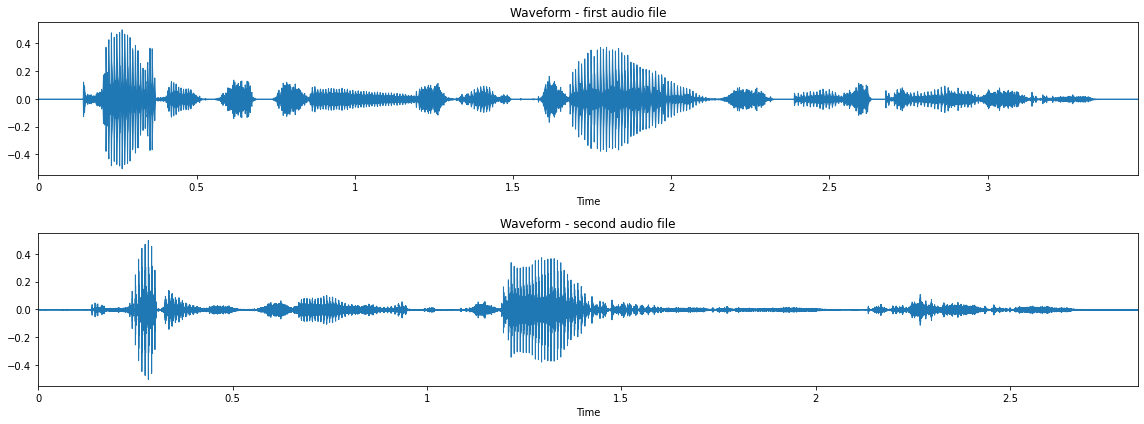

In [6]:
# plot the audio waveform.
plt.figure(figsize=(16, 6))
plt.subplot(2,1,1)
librosa.display.waveplot(d1, sr=sr1)
plt.title('Waveform - first audio file')
plt.tight_layout()
plt.subplot(2,1,2)
librosa.display.waveplot(d2, sr=sr2)
plt.title('Waveform - second audio file')
plt.tight_layout()


In [7]:
ipd.Audio(d1, rate=sr1)

In [8]:
ipd.Audio(d2, rate=sr2)

Listen to the two recordings toghether to verify they are not synchronized.

In [9]:
ml = np.min([len(d1), len(d2)])
audio_1_s = d1[:ml]
audio_2_s = d2[:ml]
audio_stereo = np.hstack((audio_2_s.reshape(-1, 1), audio_1_s.reshape(-1, 1)))

print('Not synchronized versions', flush=True)
ipd.display(ipd.Audio(audio_stereo.T, rate=sr1, normalize=True))

Not synchronized versions


### 2) Espectrogramas

In [10]:
# short-time Fourier transforms
hop_size = 128
n_fft = 512
D1C = librosa.stft(d1, n_fft=n_fft, hop_length=hop_size)
D2C = librosa.stft(d2, n_fft=n_fft, hop_length=hop_size)
# use magnitude to calculate similarity (ignore phase)
D1 = np.abs(D1C)
D2 = np.abs(D2C)

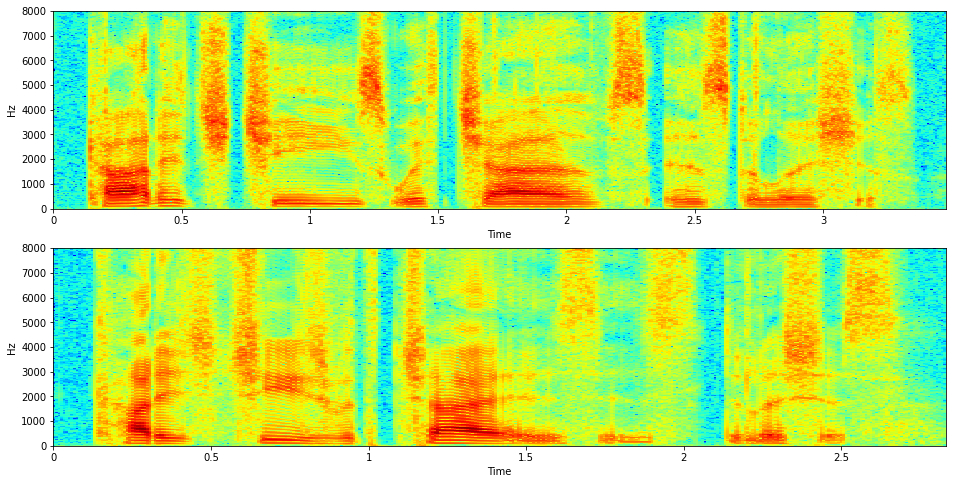

In [11]:
# plot the spectrograms (similar sequence of sounds, but different timing details)
plt.figure(figsize=(16, 8))
plt.subplot(2,1,1)
librosa.display.specshow(20*np.log10(D1), sr=sr1, hop_length=128, y_axis="linear", x_axis="time", cmap='jet')
plt.subplot(2,1,2)
librosa.display.specshow(20*np.log10(D2), sr=sr2, hop_length=128, y_axis="linear", x_axis="time", cmap='jet')

### 3) Matriz de similitud

In [12]:
# cosine similarity matrix (slow one-liner)
# each cell SM[i,j] is the cosine similarity between D1[:,i] and D2[:,j]
# i.e. the inner product of the two unit-normalized feature vectors
SM = np.array([[np.sum(a*b)/np.sqrt(np.sum(a**2)*np.sum(b**2)) for b in D2.T] for a in D1.T])

[]

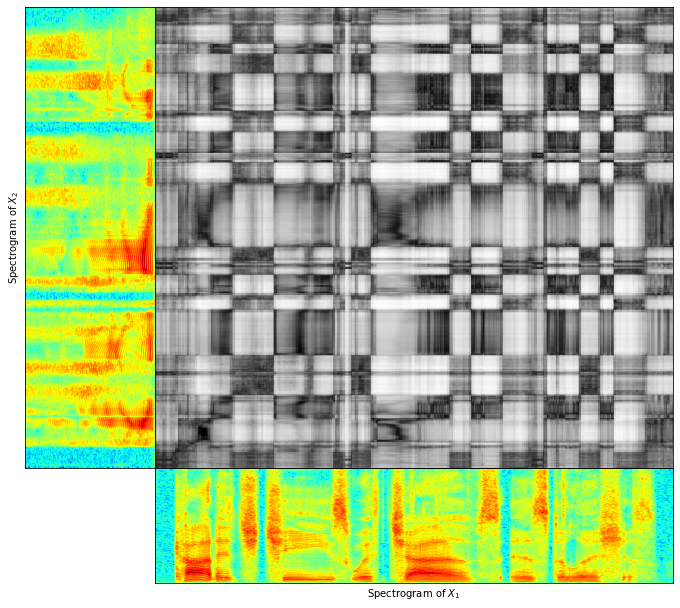

In [13]:
# plot local similarity matrix
plt.figure(figsize=(9, 8))

# spectrogram of X_1 (bottom right plot).
ax1 = plt.axes([0.2, 0, 0.8, 0.20])
ax1.imshow(20*np.log10(D1), origin='lower', aspect='auto', cmap='jet')
ax1.set_xlabel('Spectrogram of $X_1$')
ax1.set_xticks([])
ax1.set_yticks([])

# spectrogram of X_2 (top left plot).
ax2 = plt.axes([0, 0.2, 0.20, 0.8])
ax2.imshow(20*np.log10(D2).T[:,::-1], origin='lower', aspect='auto', cmap='jet')
ax2.set_ylabel('Spectrogram of $X_2$')
ax2.set_xticks([])
ax2.set_yticks([])

# local similarity matrix (top right plot).
ax3 = plt.axes([0.2, 0.2, 0.8, 0.8])
ax3.imshow(SM, aspect='auto', origin='lower', interpolation='none', cmap='binary')
ax3.axis([0, np.size(D2, axis=1), 0, np.size(D1, axis=1)])
ax3.set_xticks([])
ax3.set_yticks([])

### 4) Dynamic Time Warping

In [15]:
# find the minimum-cost path.  We use 1-SM so that cosine similarity == 1 -> cost = 0
# penalty is the additional cost incurred by non-diagonal steps (promotes diagonality)
localcost = np.array(1.0-SM, order='C', dtype=float)
p, q, C, phi = dp(localcost, penalty=0.1)
# p and q are vectors giving the row and column indices along the best path
# C returns the full minimum-cost matrix, and phi is the full traceback matrix

[]

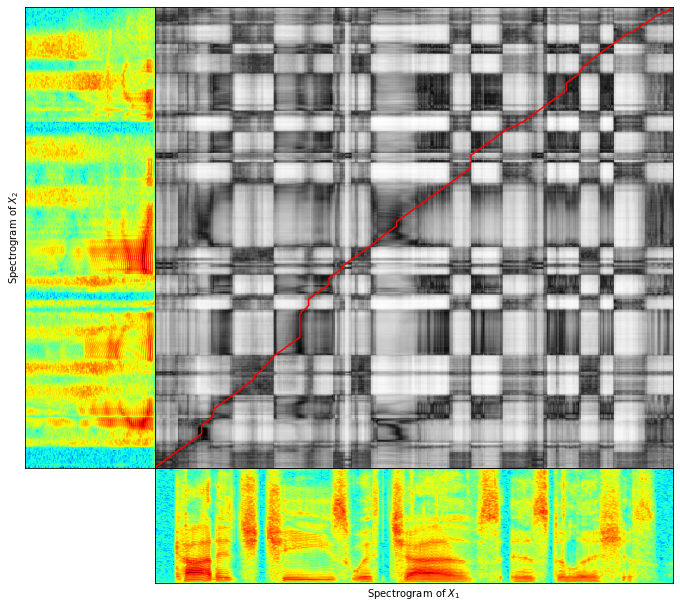

In [16]:
# plot the best path on top of local similarity matrix
plt.figure(figsize=(9, 8))

# bottom right plot.
ax1 = plt.axes([0.2, 0, 0.8, 0.20])
ax1.imshow(20*np.log10(D1), origin='lower', aspect='auto', cmap='jet')
ax1.set_xlabel('Spectrogram of $X_1$')
ax1.set_xticks([])
ax1.set_yticks([])

# top left plot.
ax2 = plt.axes([0, 0.2, 0.20, 0.8])
ax2.imshow(20*np.log10(D2).T[:,::-1], origin='lower', aspect='auto', cmap='jet')
ax2.set_ylabel('Spectrogram of $X_2$')
ax2.set_xticks([])
ax2.set_yticks([])

# top right plot.
ax3 = plt.axes([0.2, 0.2, 0.8, 0.8])
#ax3.imshow(D.T, aspect='auto', origin='lower', interpolation='nearest', cmap='gray')
ax3.imshow(SM, aspect='auto', origin='lower', interpolation='none', cmap='binary')
#ax3.imshow(SM, interpolation='nearest', origin='lower', cmap='gray')
ax3.plot(q,p,'-r')
ax3.axis([0, np.size(D2, axis=1), 0, np.size(D1, axis=1)])
ax3.set_xticks([])
ax3.set_yticks([])

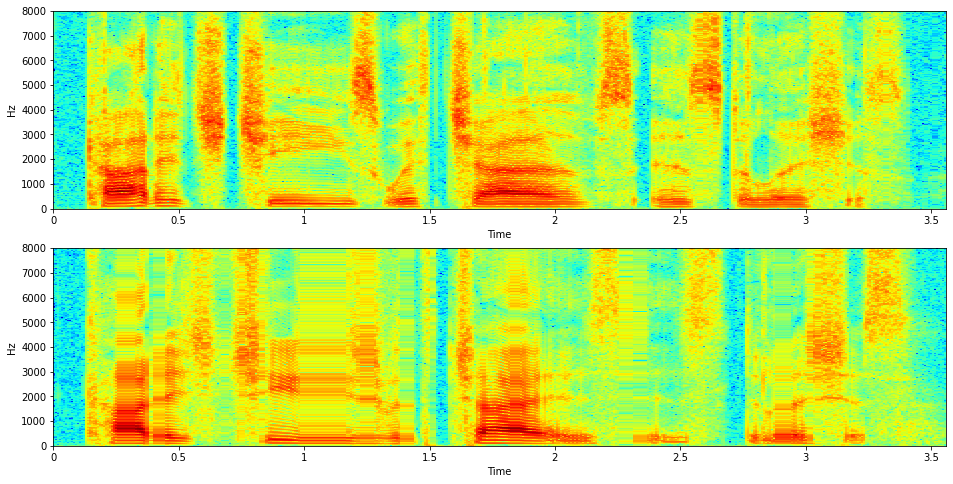

In [17]:
# we can use the best-aligned columns to plot aligned spectrograms
# notice how the features in the two spectrograms are now lined up horizontally
plt.figure(figsize=(16, 8))
plt.subplot(2,1,1)
librosa.display.specshow(20*np.log10(D1[:, p]), sr=sr1, hop_length=128, y_axis="linear", x_axis="time", cmap='jet')
plt.subplot(2,1,2)
librosa.display.specshow(20*np.log10(D2[:, q]), sr=sr2, hop_length=128, y_axis="linear", x_axis="time", cmap='jet')

### 5) Listen to aligned audio

In [19]:
# download audio files
wget.download('https://github.com/mrocamora/audio-dsp/blob/main/audio/speech_stereo_matched.wav?raw=true')

'speech_stereo_matched.wav'

In [20]:
# Load stereo aligned audio
d_aligned, sr_aligned = librosa.load('speech_stereo_matched.wav', sr=None)

In [22]:
# To play matched audio file
ipd.Audio(d_aligned, rate=sr_aligned)